In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from guide.dataset import GuideDataset
from guide.plot_helpers import *

In [2]:
dataset = GuideDataset('data/example_guide_data_with_bowtie_with_mfold.tsv')
points = dataset.points
points = list(filter(lambda p: p.mfold_result().dG < 900, points))

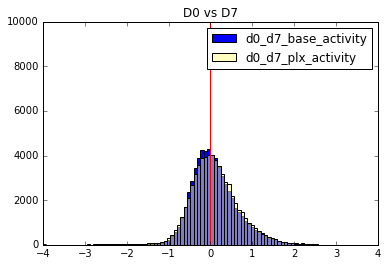

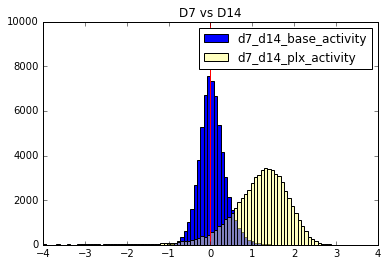

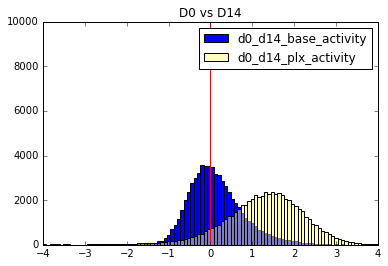

In [3]:
compare_activities(0, 7, points)
compare_activities(7, 14, points)
compare_activities(0, 14, points)

In [4]:
d7_d14_base_activities = [p.d7_d14_base_activity() for p in points]

sigma, mean = numpy.std(d7_d14_base_activities), numpy.mean(d7_d14_base_activities)

print('average activity', mean)
print('standard deviation', sigma)

outside_d7_d14_range = lambda p: p.d0_d7_base_activity() > 3*sigma
inside_d7_d14_range = lambda p: p.d0_d7_base_activity() < -0.5*sigma

active_points = list(filter(outside_d7_d14_range, points))
inactive_points = list(filter(inside_d7_d14_range, points))

print('out of', len(points), 'points, approximately', len(active_points), 'are active')
print('out of', len(points), 'points, approximately', len(inactive_points), 'are inactive')

average activity 0.0374885138514
standard deviation 0.308318508294
out of 63815 points, approximately 5129 are active
out of 63815 points, approximately 22804 are inactive


In [5]:
active_point_genes = set([p.row['gene_name'] for p in active_points])

print('from the', len(active_points), 'active points, there are', len(active_point_genes), 'active genes')

has_active_point_gene = lambda p: p.row['gene_name'] in active_point_genes

same_gene_inactive_points = list(filter(has_active_point_gene, inactive_points))

print('there are', len(same_gene_inactive_points), 'inactive points on the same genes')

from the 5129 active points, there are 3900 active genes
there are 3448 inactive points on the same genes


In [6]:
split_points = active_points + same_gene_inactive_points
print('new dataset is', len(split_points)/float(len(points)), 'times the original dataset size')

new dataset is 0.13440413695839537 times the original dataset size


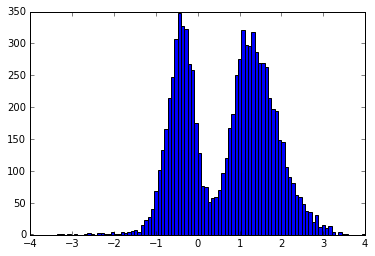

In [7]:
plot_activity(0, 14, 'base', split_points)

In [8]:
split_point_groups = [
    ['active', active_points],
    ['inactive', same_gene_inactive_points]
]



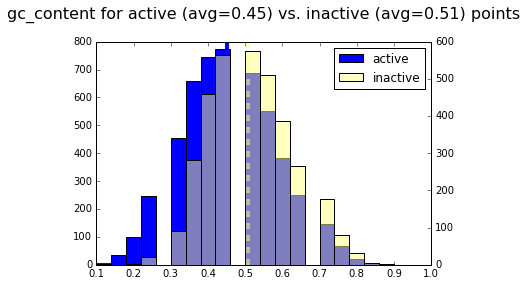

In [9]:
compare_point_groups_by('gc_content', split_point_groups)


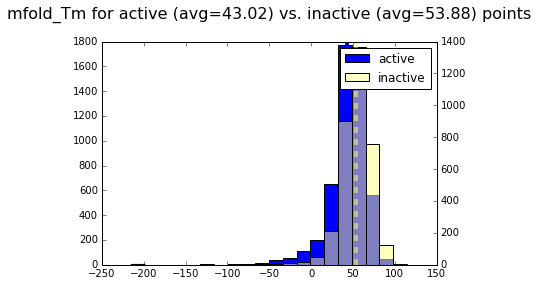

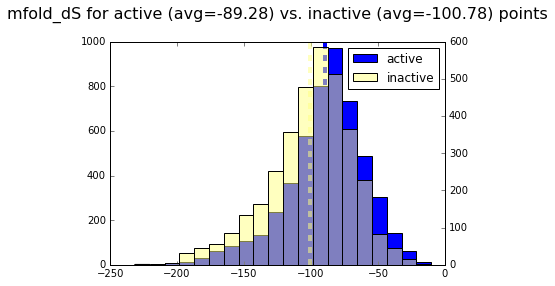

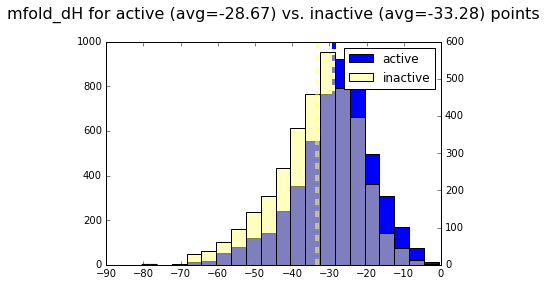

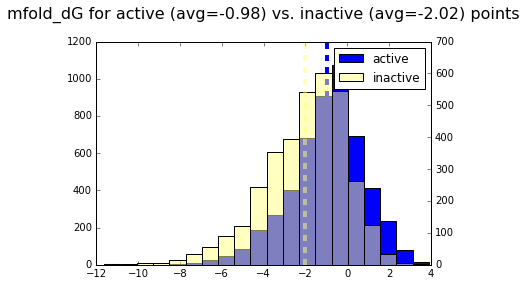

In [10]:
compare_point_groups_by('mfold_Tm', split_point_groups)
compare_point_groups_by('mfold_dS', split_point_groups)
compare_point_groups_by('mfold_dH', split_point_groups)
compare_point_groups_by('mfold_dG', split_point_groups)

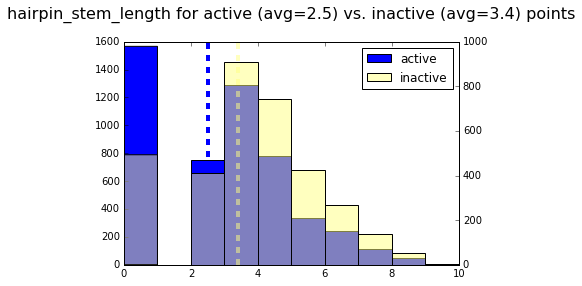

In [11]:
compare_point_groups_by('hairpin_stem_length', split_point_groups, 10, (0, 10))

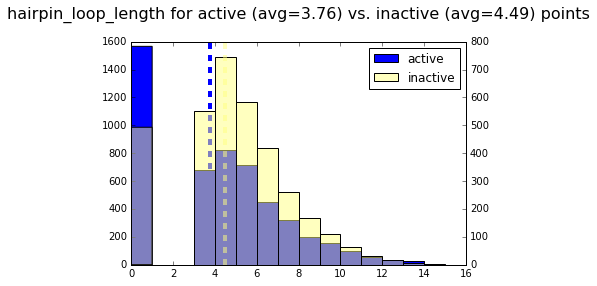

In [12]:
compare_point_groups_by('hairpin_loop_length', split_point_groups, 15, (0,15))

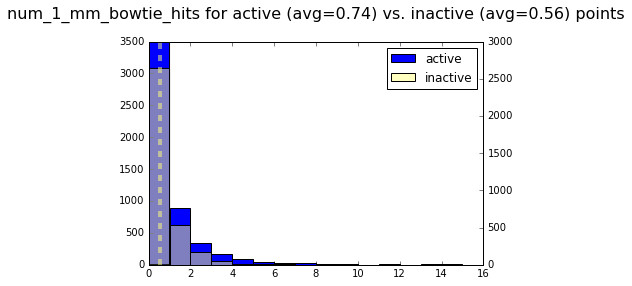

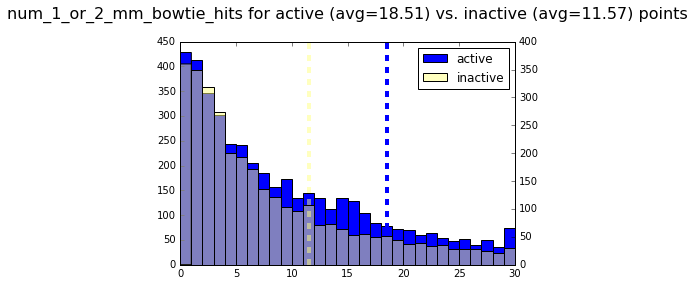

In [19]:
compare_point_groups_by('num_1_mm_bowtie_hits', split_point_groups, 15, (0,15))
compare_point_groups_by('num_1_or_2_mm_bowtie_hits', split_point_groups, 30, (0,30))

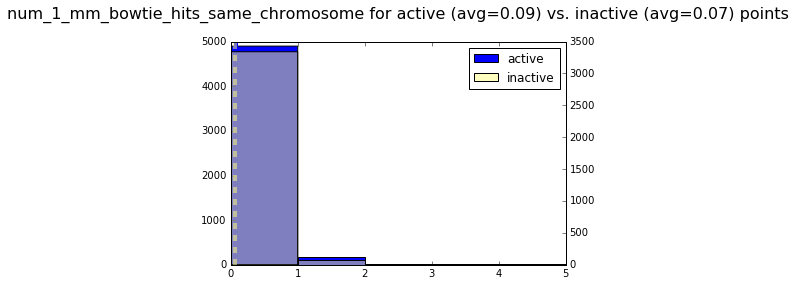

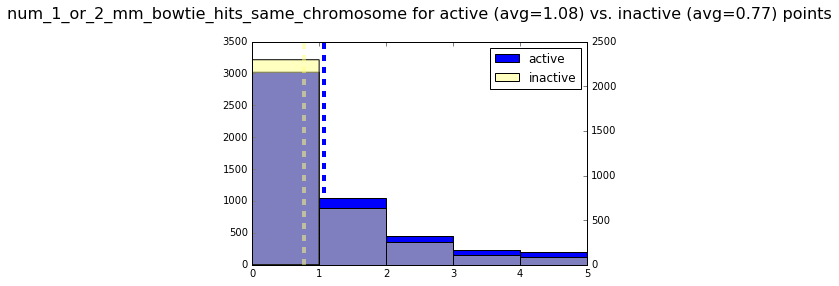

In [22]:
compare_point_groups_by('num_1_mm_bowtie_hits_same_chromosome', split_point_groups, 5, (0,5))
compare_point_groups_by('num_1_or_2_mm_bowtie_hits_same_chromosome', split_point_groups, 5, (0,5))

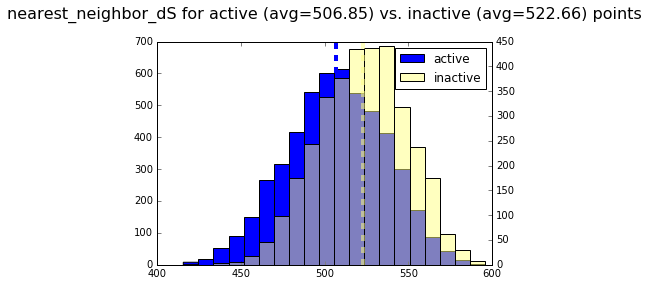

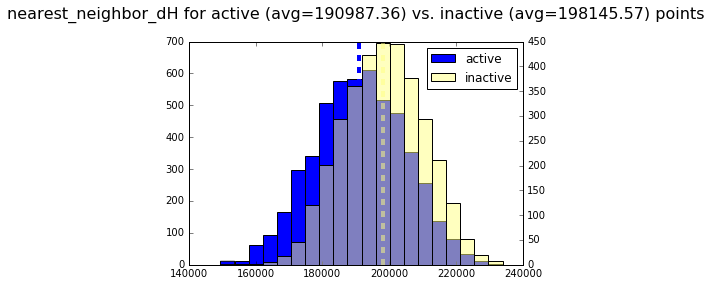

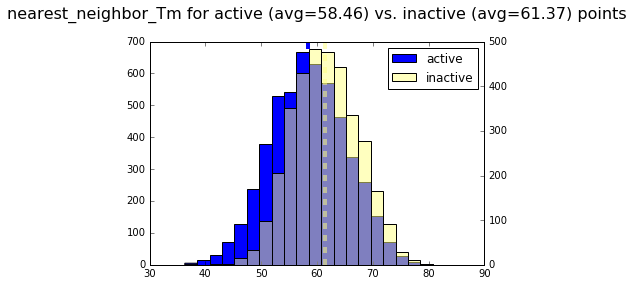

In [25]:
compare_point_groups_by('nearest_neighbor_dS', split_point_groups)
compare_point_groups_by('nearest_neighbor_dH', split_point_groups)
compare_point_groups_by('nearest_neighbor_Tm', split_point_groups)

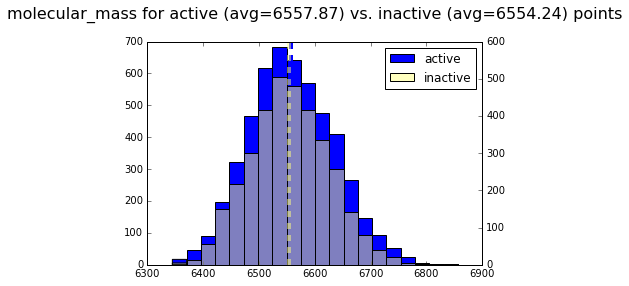

In [26]:
compare_point_groups_by('molecular_mass', split_point_groups)

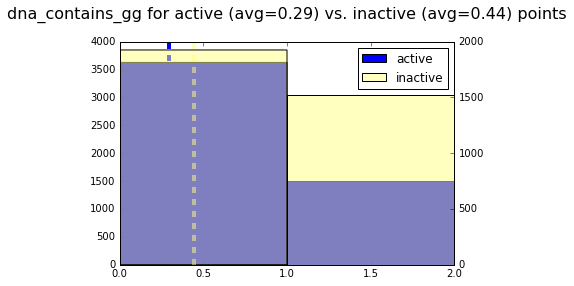

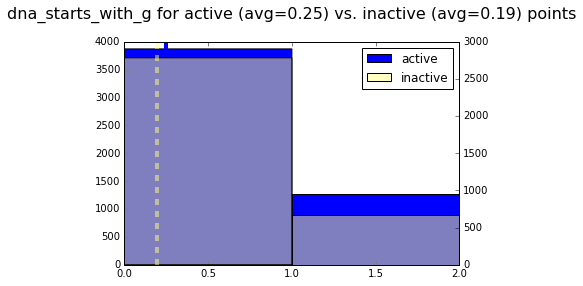

In [32]:
compare_point_groups_by('dna_contains_gg', split_point_groups, 2, (0,2))
compare_point_groups_by('dna_starts_with_g', split_point_groups, 2, (0,2))